INFO:__main__:Database connection successful
INFO:__main__:Data loaded successfully. Shape: (28, 36)
INFO:__main__:Zero and missing value analysis completed
INFO:__main__:
Initial Data Analysis:
INFO:__main__:Missing Values Percentage:
INFO:__main__:Apr_2022     7.142857
Apr_2023     7.142857
Apr_2024    10.714286
Aug_2022     7.142857
Aug_2023     7.142857
Aug_2024     0.000000
Dec_2022     7.142857
Dec_2023     7.142857
Feb_2022     7.142857
Feb_2023     7.142857
Feb_2024    14.285714
Jan_2022     7.142857
Jan_2023     7.142857
Jan_2024     7.142857
Jul_2022     7.142857
Jul_2023     7.142857
Jul_2024    10.714286
Jun_2022     7.142857
Jun_2023     7.142857
Jun_2024     7.142857
Mar_2022     7.142857
Mar_2023     7.142857
Mar_2024    10.714286
May_2022     7.142857
May_2023     7.142857
May_2024    14.285714
Nov_2022     7.142857
Nov_2023     7.142857
Nov_2024     0.000000
Oct_2022     7.142857
Oct_2023     7.142857
Oct_2024     0.000000
Sep_2022     7.142857
Sep_2023     7.142857
Se

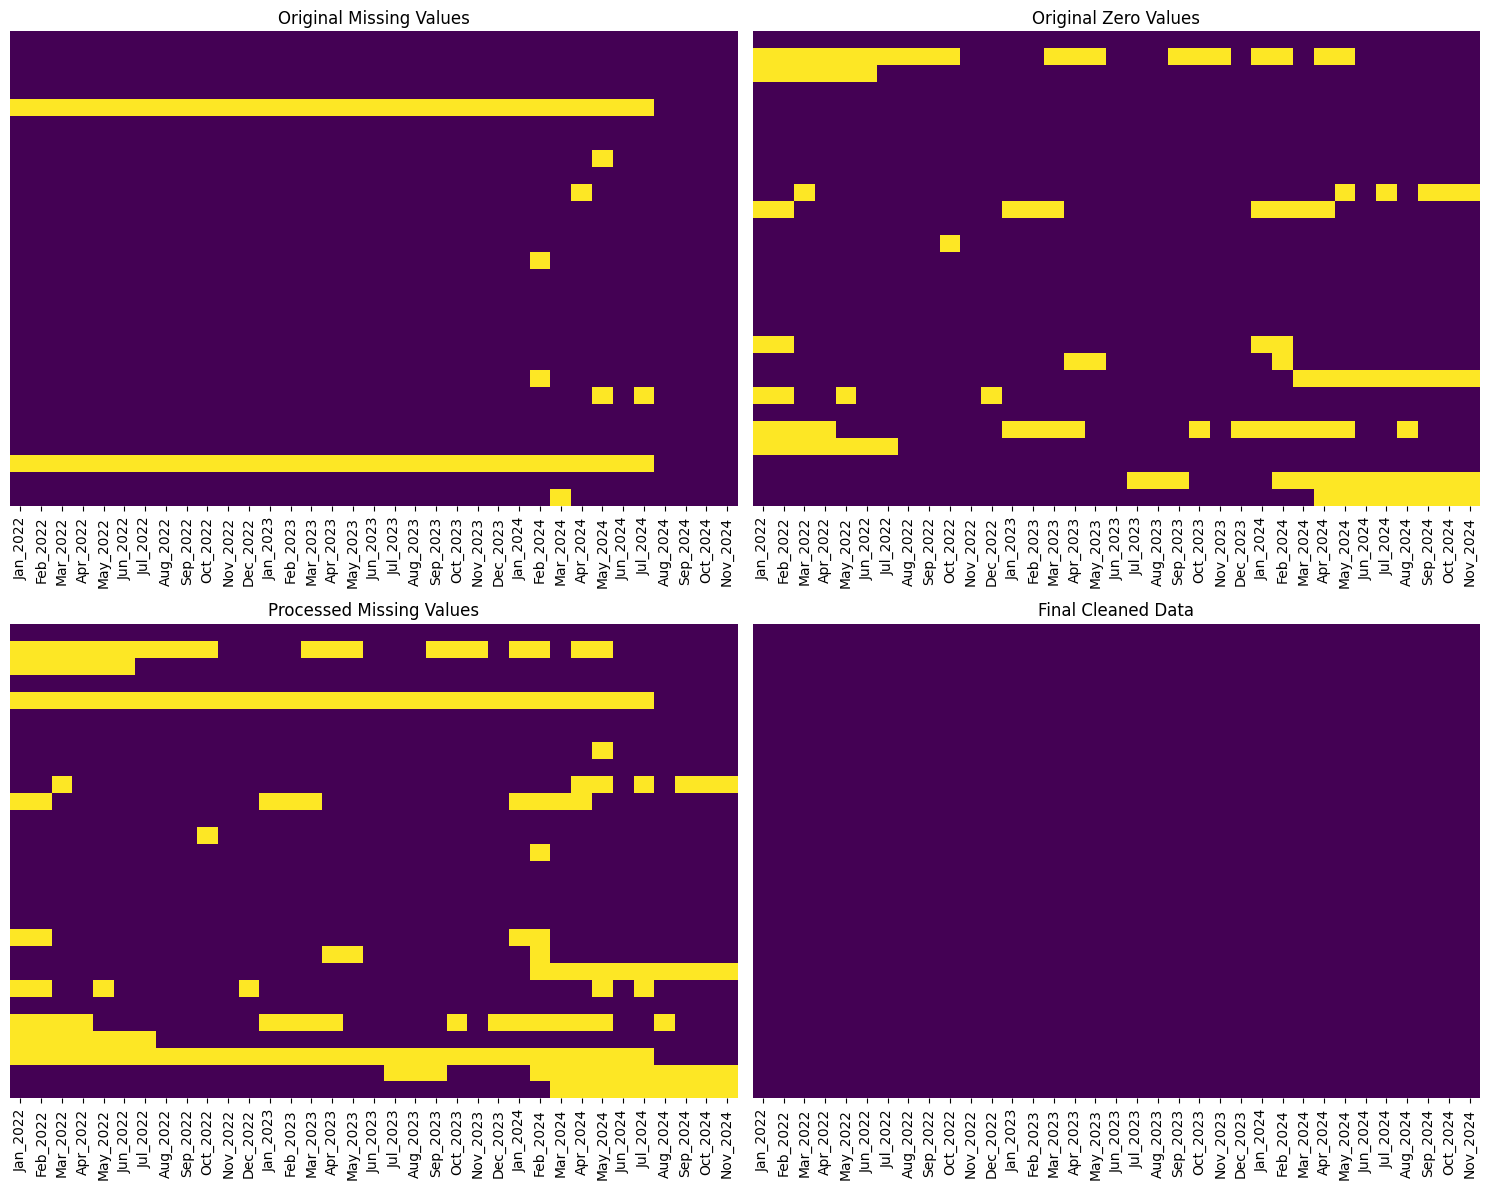

INFO:__main__:Data saved successfully to gas_automated_meter_cleaned


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from datetime import datetime
from decouple import config, Config, RepositoryEnv
import os
from pathlib import Path
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Environment setup
try:
    current_dir = Path(os.getcwd())
    env_path = current_dir.parents[1] / '.env'
    config = Config(RepositoryEnv(env_path))
except Exception as e:
    logger.error(f"Error loading environment file: {e}")
    raise

# Database connection parameters with error handling
try:
    DB_PARAMS = {
        'host': config('DB_HOST', default='localhost'),
        'database': config('DB_NAME', default='uems_db'),
        'user': config('DB_USER', default='postgres'),
        'password': config('DB_PASSWORD'),
        'port': config('DB_PORT', default=5432),
        'schema': config('DB_SCHEMA', default='dbo')
    }
    db_url = f"postgresql://{DB_PARAMS['user']}:{DB_PARAMS['password']}@{DB_PARAMS['host']}:{DB_PARAMS['port']}/{DB_PARAMS['database']}"
except Exception as e:
    logger.error(f"Error setting up database parameters: {e}")
    raise

def connect_to_database(db_url):
    """Create database connection with error handling"""
    try:
        engine = create_engine(db_url)
        # Test connection
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        logger.info("Database connection successful")
        return engine
    except Exception as e:
        logger.error(f"Error connecting to database: {e}")
        return None

def load_gas_data(engine, table_name='dbo.gas_automated_meter'):
    """Load data from database and exclude future months"""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, engine)
        
        # Columns to exclude
        exclude_columns = [
            'Dec_2024', 'Jan_2025', 'Feb_2025', 'Mar_2025',
            'created_at', 'updated_at', 'id', 'icp'
        ]
        
        # Drop specified columns if they exist
        columns_to_drop = [col for col in exclude_columns if col in df.columns]
        df_cleaned = df.drop(columns=columns_to_drop)
        
        logger.info(f"Data loaded successfully. Shape: {df_cleaned.shape}")
        return df_cleaned
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

def preprocess_meter_readings(df):
    """Preprocess meter readings by handling zeros, NULL, and rounding values"""
    try:
        df_processed = df.copy()
        
        # Get all columns except 'meter_description'
        value_columns = df_processed.columns.difference(['meter_description'])
        
        # Convert columns to numeric, replacing non-numeric and NULL values with NaN
        for col in value_columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            
        # Replace 0 values with NaN
        df_processed[value_columns] = df_processed[value_columns].replace([0, 'NULL', None], np.nan)
        
        # Round all numeric values to 2 decimal places
        df_processed[value_columns] = df_processed[value_columns].round(2)
        
        logger.info("Zero, NULL values converted to NaN and numbers rounded to 2 decimal places")
        return df_processed
    except Exception as e:
        logger.error(f"Error preprocessing meter readings: {e}")
        raise

def analyze_zero_and_missing_values(df):
    """Analyze zero and missing values in dataframe"""
    try:
        # Get numeric columns excluding meter_description
        numeric_cols = df.columns.difference(['meter_description'])
        
        analysis_stats = {
            'total_missing': df[numeric_cols].isnull().sum(),
            'missing_percentage': (df[numeric_cols].isnull().sum() / len(df) * 100),
            'zero_values': (df[numeric_cols] == 0).sum(),
            'zero_percentage': (df[numeric_cols] == 0).sum() / len(df) * 100
        }
        
        logger.info("Zero and missing value analysis completed")
        return analysis_stats
    except Exception as e:
        logger.error(f"Error analyzing zero and missing values: {e}")
        raise

def handle_missing_values(df):
    """Handle missing values with multiple methods and set remaining nulls to 0"""
    try:
        df_imputed = df.copy()
        numeric_cols = df_imputed.columns.difference(['meter_description'])
        
        for col in numeric_cols:
            # Calculate meter-specific statistics
            meter_stats = df_imputed.groupby('meter_description')[col].agg(['mean', 'std']).round(2).reset_index()
            meter_stats['std'] = meter_stats['std'].fillna(0)
            
            # Forward and backward fill within meter groups
            df_imputed[col] = df_imputed.groupby('meter_description')[col].ffill()
            df_imputed[col] = df_imputed.groupby('meter_description')[col].bfill()
            
            # Handle remaining missing values with seasonal patterns
            if '_' in col:
                month = col.split('_')[0]
                year_cols = [c for c in numeric_cols if c.startswith(month)]
                seasonal_mean = df_imputed[year_cols].mean(axis=1).round(2)
                df_imputed[col] = df_imputed[col].fillna(seasonal_mean)
            
            # Set any remaining nulls to 0
            df_imputed[col] = df_imputed[col].fillna(0)
            
            # Round values after operations
            df_imputed[col] = df_imputed[col].round(2)
        
        logger.info("Missing values handled successfully and remaining nulls set to 0")
        return df_imputed
    except Exception as e:
        logger.error(f"Error handling missing values: {e}")
        raise


        
def save_cleaned_data(df, engine, table_name='gas_automated_meter_cleaned'):
    """Save cleaned data to database"""
    try:
        df.to_sql(table_name, engine, if_exists='replace', index=False, schema='dbo')
        logger.info(f"Data saved successfully to {table_name}")
    except Exception as e:
        logger.error(f"Error saving cleaned data: {e}")
        raise

def main():
    try:
        # Connect to database
        engine = connect_to_database(db_url)
        if not engine:
            return
        
        # Load data
        df = load_gas_data(engine)
        
        # Analyze initial state
        initial_stats = analyze_zero_and_missing_values(df)
        logger.info("\nInitial Data Analysis:")
        logger.info("Missing Values Percentage:")
        logger.info(initial_stats['missing_percentage'])
        logger.info("\nZero Values Percentage:")
        logger.info(initial_stats['zero_percentage'])
        
        # Preprocess data (handle zeros and NULLs)
        df_processed = preprocess_meter_readings(df)
        
        # Handle missing values
        df_cleaned = handle_missing_values(df_processed)
        
        # Verify cleaned data
        final_stats = analyze_zero_and_missing_values(df_cleaned)
        logger.info("\nFinal Data Analysis:")
        logger.info("Remaining Missing Values:")
        logger.info(final_stats['missing_percentage'])
        logger.info("\nRemaining Zero Values:")
        logger.info(final_stats['zero_percentage'])
        
        # Visualize before and after
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Original missing values
        sns.heatmap(df.select_dtypes(include=[np.number]).isnull(), 
                   yticklabels=False, cbar=False, cmap='viridis', ax=axes[0,0])
        axes[0,0].set_title('Original Missing Values')
        
        # Original zero values
        zero_mask = df.select_dtypes(include=[np.number]) == 0
        sns.heatmap(zero_mask, yticklabels=False, cbar=False, cmap='viridis', ax=axes[0,1])
        axes[0,1].set_title('Original Zero Values')
        
        # Processed missing values
        sns.heatmap(df_processed.select_dtypes(include=[np.number]).isnull(), 
                   yticklabels=False, cbar=False, cmap='viridis', ax=axes[1,0])
        axes[1,0].set_title('Processed Missing Values')
        
        # Final cleaned data
        sns.heatmap(df_cleaned.select_dtypes(include=[np.number]).isnull(), 
                   yticklabels=False, cbar=False, cmap='viridis', ax=axes[1,1])
        axes[1,1].set_title('Final Cleaned Data')
        
        plt.tight_layout()
        plt.show()
        
        # Save cleaned dataset
        save_cleaned_data(df_cleaned, engine)
        
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        raise

if __name__ == "__main__":
    main()
